In [12]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [13]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms



In [14]:
from pathlib import Path

data_path = Path("Dataset")

train_dir = data_path / "train"
test_dir = data_path / "test"

train_dir, test_dir

(WindowsPath('Dataset/train'), WindowsPath('Dataset/test'))

In [15]:
def TransferLearning_effnet(num_classes: int=2,
                              seed: int=42):
    #Инициализация базовых весов модели efficientNet
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    
    #Трансформер изображений по подключенной структуре
    transforms =  weights.transforms()
    
    #Стартовая модель
    model = torchvision.models.efficientnet_b0(weights=weights)
    
    #Для того, чтобы слои не были преобразованы, замораживаем их
    for param in model.parameters():
        param.requires_grad = False
        
    #Для способности повторно проводить эксперимент используем сид весов 42
    torch.manual_seed(seed)
    
    #Преобразуем кол-во классов в необходимое для нас
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1280, out_features=num_classes)
    )
    return model, transforms

In [16]:
# Создаем модель и трансформеры
effnet, effnet_transforms = TransferLearning_effnet(num_classes=2,
                                                      seed=42)

# Настраиваем dataloader
from Modules import Setup

train_dataloader_effnet, test_dataloader_effnet, class_names = Setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=effnet_transforms,
    batch_size=32
)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\Andrew/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 41.5MB/s]


In [17]:
from torchinfo import summary

#Наша архитектура
summary(effnet,
        input_size=(1,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 2]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

Момент обучения модели

In [18]:
from Modules import TrainModule
from Modules.Auxiliary_Functions import set_seeds, Graph_loss

set_seeds()

effnet_trained = TrainModule.train(model=effnet,
                                     train_dataloader=train_dataloader_effnet,
                                     test_dataloader=test_dataloader_effnet,
                                     epoch=10,
                                     optimizer=torch.optim.Adam(params=effnet.parameters(), lr=1e-3),
                                     loss_fn=torch.nn.CrossEntropyLoss(),
                                     device=device)

 10%|█         | 1/10 [00:59<08:55, 59.46s/it]

Epoch: 1 | Train Loss: 0.326 | Train Acc: 0.880 | Test Loss: 0.126 |Test Acc: 0.974


 20%|██        | 2/10 [01:57<07:50, 58.79s/it]

Epoch: 2 | Train Loss: 0.175 | Train Acc: 0.943 | Test Loss: 0.090 |Test Acc: 0.976


 30%|███       | 3/10 [02:55<06:49, 58.44s/it]

Epoch: 3 | Train Loss: 0.154 | Train Acc: 0.946 | Test Loss: 0.068 |Test Acc: 0.982


 40%|████      | 4/10 [03:53<05:49, 58.30s/it]

Epoch: 4 | Train Loss: 0.131 | Train Acc: 0.959 | Test Loss: 0.067 |Test Acc: 0.986


 50%|█████     | 5/10 [04:52<04:52, 58.40s/it]

Epoch: 5 | Train Loss: 0.113 | Train Acc: 0.962 | Test Loss: 0.062 |Test Acc: 0.980


 60%|██████    | 6/10 [05:50<03:53, 58.40s/it]

Epoch: 6 | Train Loss: 0.120 | Train Acc: 0.961 | Test Loss: 0.053 |Test Acc: 0.988


 70%|███████   | 7/10 [06:48<02:54, 58.29s/it]

Epoch: 7 | Train Loss: 0.107 | Train Acc: 0.961 | Test Loss: 0.046 |Test Acc: 0.986


 80%|████████  | 8/10 [07:47<01:56, 58.25s/it]

Epoch: 8 | Train Loss: 0.095 | Train Acc: 0.968 | Test Loss: 0.050 |Test Acc: 0.986


 90%|█████████ | 9/10 [08:44<00:58, 58.14s/it]

Epoch: 9 | Train Loss: 0.092 | Train Acc: 0.968 | Test Loss: 0.048 |Test Acc: 0.984


100%|██████████| 10/10 [09:43<00:00, 58.33s/it]

Epoch: 10 | Train Loss: 0.096 | Train Acc: 0.962 | Test Loss: 0.043 |Test Acc: 0.988


In [19]:
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

# Функция инференса
def pred_and_store(paths: List[Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str]) -> List[str]:
    device = "cpu"
    predictions = []

    # Обрабатываем каждое изображение в списке путей
    for path in paths:
        # Открываем каждый файл отдельно
        img = Image.open(path).convert("RGB")

        # Трансформируем изображение и отправляем на CPU
        transformed_image = transform(img).unsqueeze(0).to(device)

        model.to(device)
        model.eval()

        # Производим инференс
        with torch.inference_mode():
            pred_logit = model(transformed_image)
            pred_prob = torch.softmax(pred_logit, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1)
            pred_class = class_names[pred_label.cpu()]

        # Добавляем результат в список
        predictions.append(pred_class)

    return predictions

[INFO] Saving model to: models\kt4.pth
Pretrained EffNet feature extractor model size: 15 MB


{'test_loss': 0.042891619610600173,
 'test_acc': 0.98828125,
 'number_of_parameters': 4010110,
 'model_size (MB)': 15}

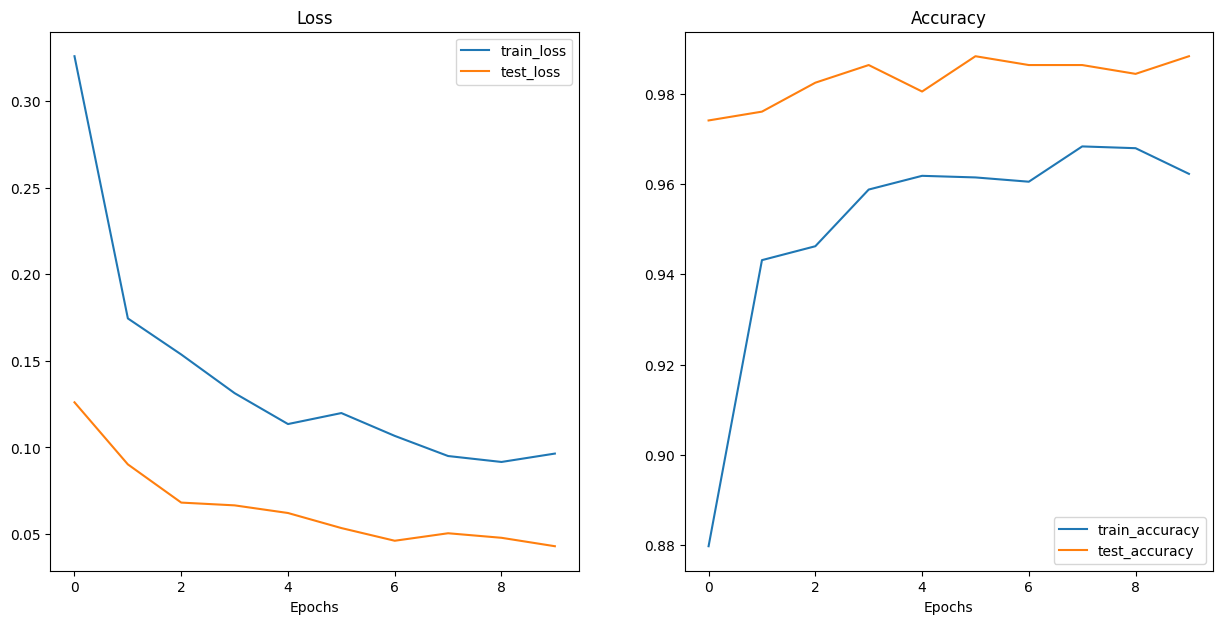

In [20]:
# Генерируем график того, как обучалась модель
Graph_loss(effnet_trained)

from Modules import Savekt

#Сохраняем полученную модель
Savekt.save_model(model=effnet,
                  target_dir="models",
                  model_name="kt4.pth")

# Считаем количество параметров в модели
effnet_total_params = sum(
    torch.numel(param) for param in effnet.parameters())
effnet_total_params

# Рассчитываем вес полученной модели в мб
pretrained_effnet_model_size = Path(
    "models/kt4.pth").stat().st_size // (
                                         1024 * 1024)  # division converts bytes to megabytes (roughly)
print(
    f"Pretrained EffNet feature extractor model size: {pretrained_effnet_model_size} MB")

# Формируем словарь с результатами модели (для сравнения с другими моделями и результатами тренировок)
effnet_stats = {"test_loss": effnet_trained["test_loss"][-1],
                  "test_acc": effnet_trained["test_acc"][-1],
                  "number_of_parameters": effnet_total_params,
                  "model_size (MB)": pretrained_effnet_model_size}
effnet_stats